In [1]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
import pandas as pd
from src import util
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from peft import LoraConfig, get_peft_model
import wandb
from src.util import MultiOutputLayer, MultiOutputClipModel, MultiOutputClipCriterion
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# load state_dict from model/2_output_clip_model-2.pth

device = "cuda" if torch.cuda.is_available() else "cpu"
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", 
#                                   cache_dir="model", local_files_only=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", 
                                          cache_dir="model", local_files_only=True)

# mo_model = util.MultiOutputClipModel(model, selected_class_names, 768, 128, 512)
# mo_model.load_state_dict(torch.load('model/2_output_clip_model-2.pth'))

mo_model = torch.load("model/2_output_clip_model.pt").to(device)

/home/user/miniforge3/envs/hf/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_38889/2315961251.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

In [4]:
data_dir = "data"
# articles_filtered: remove articles with no images
articles = pd.read_csv(f"{data_dir}/articles_filtered.csv")

In [5]:
# map from article_id to df index
article_id_to_idx = {article_id: idx for idx, article_id in enumerate(articles["article_id"])}

# get all classes of the dataframe
class_names = articles.columns.tolist()
label_names = dict()
label_names_to_idx = dict()
for class_name in class_names:
    label_names[class_name] = articles[class_name].unique()
    label_names_to_idx[class_name] = {label_name: idx for idx, label_name in enumerate(label_names[class_name])}

article_ids = label_names["article_id"]
# selected_class_names = ["product_group_name", "product_type_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]
selected_class_names = ["product_type_name", "graphical_appearance_name"]

In [6]:
# grouped by product_code
grouped = articles.groupby("product_code")
groups = [group for _, group in grouped]

# split 0.8/0.1/0.1
train_groups, test_groups = train_test_split(groups, test_size=0.2, random_state=42) 
val_groups, test_groups = train_test_split(test_groups, test_size=0.5, random_state=42) 

train_df = pd.concat(train_groups)
val_df = pd.concat(val_groups)
test_df = pd.concat(test_groups)

print(f"{len(train_df)=} {len(val_df)=} {len(test_df)=}")

len(train_df)=84369 len(val_df)=10454 len(test_df)=10277


In [7]:
train_paths, train_labels = util.get_image_paths_and_labels_from_df(train_df, data_dir)
val_paths, val_labels = util.get_image_paths_and_labels_from_df(val_df, data_dir)
test_paths, test_labels = util.get_image_paths_and_labels_from_df(test_df, data_dir)

In [8]:
def validate(model, dataloader, criteria, device, text_inputs, class_names):
    model.eval()
    label_dict = dict()
    pred_dict = dict()

    with torch.no_grad():
        for images, image_ids in tqdm(dataloader):
            images = images.to(device)
            logits_per_image_dict = model(pixel_values=images, text_input_dict=text_inputs)

            # Get true labels from image_ids
            true_labels_dict = {
                class_name: [label_names_to_idx[class_name][articles.loc[article_id_to_idx[image_id.item()], class_name]] 
                           for image_id in image_ids]
                for class_name in class_names
            }
            true_labels_dict = {class_name: torch.tensor(true_labels)
                                for class_name, true_labels in true_labels_dict.items()}
            for class_name in class_names:
                label_dict[class_name] = torch.cat([label_dict.get(class_name, torch.tensor([]))
                                                    , true_labels_dict[class_name]])
                pred_dict[class_name] = torch.cat([pred_dict.get(class_name, torch.tensor([]))
                                                    , logits_per_image_dict[class_name].to("cpu")])

    return label_dict, pred_dict

In [9]:
val_dataset = util.ImageDataset(val_paths, processor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8)

test_dataset = util.ImageDataset(test_paths, processor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

In [10]:
criteria = MultiOutputClipCriterion(class_names=selected_class_names)

# generate text input
text_input_dict = {
    class_name: processor(text=[f"A photo of a {label}" for label in label_names[class_name]], 
                          return_tensors="pt", padding=True).to(device)
    for class_name in selected_class_names
}

In [11]:
label_dict, pred_dict = validate(mo_model, val_dataloader, criteria, device, text_input_dict, selected_class_names)



100%|██████████| 41/41 [01:10<00:00,  1.71s/it]


In [12]:
for class_name in selected_class_names:
    print(len(label_names[class_name]))
    print(label_dict[class_name].shape)
    print(pred_dict[class_name].shape)


131
torch.Size([10454])
torch.Size([10454, 131])
30
torch.Size([10454])
torch.Size([10454, 30])


product_type_name: 0.6854792423952554
(131, 131)


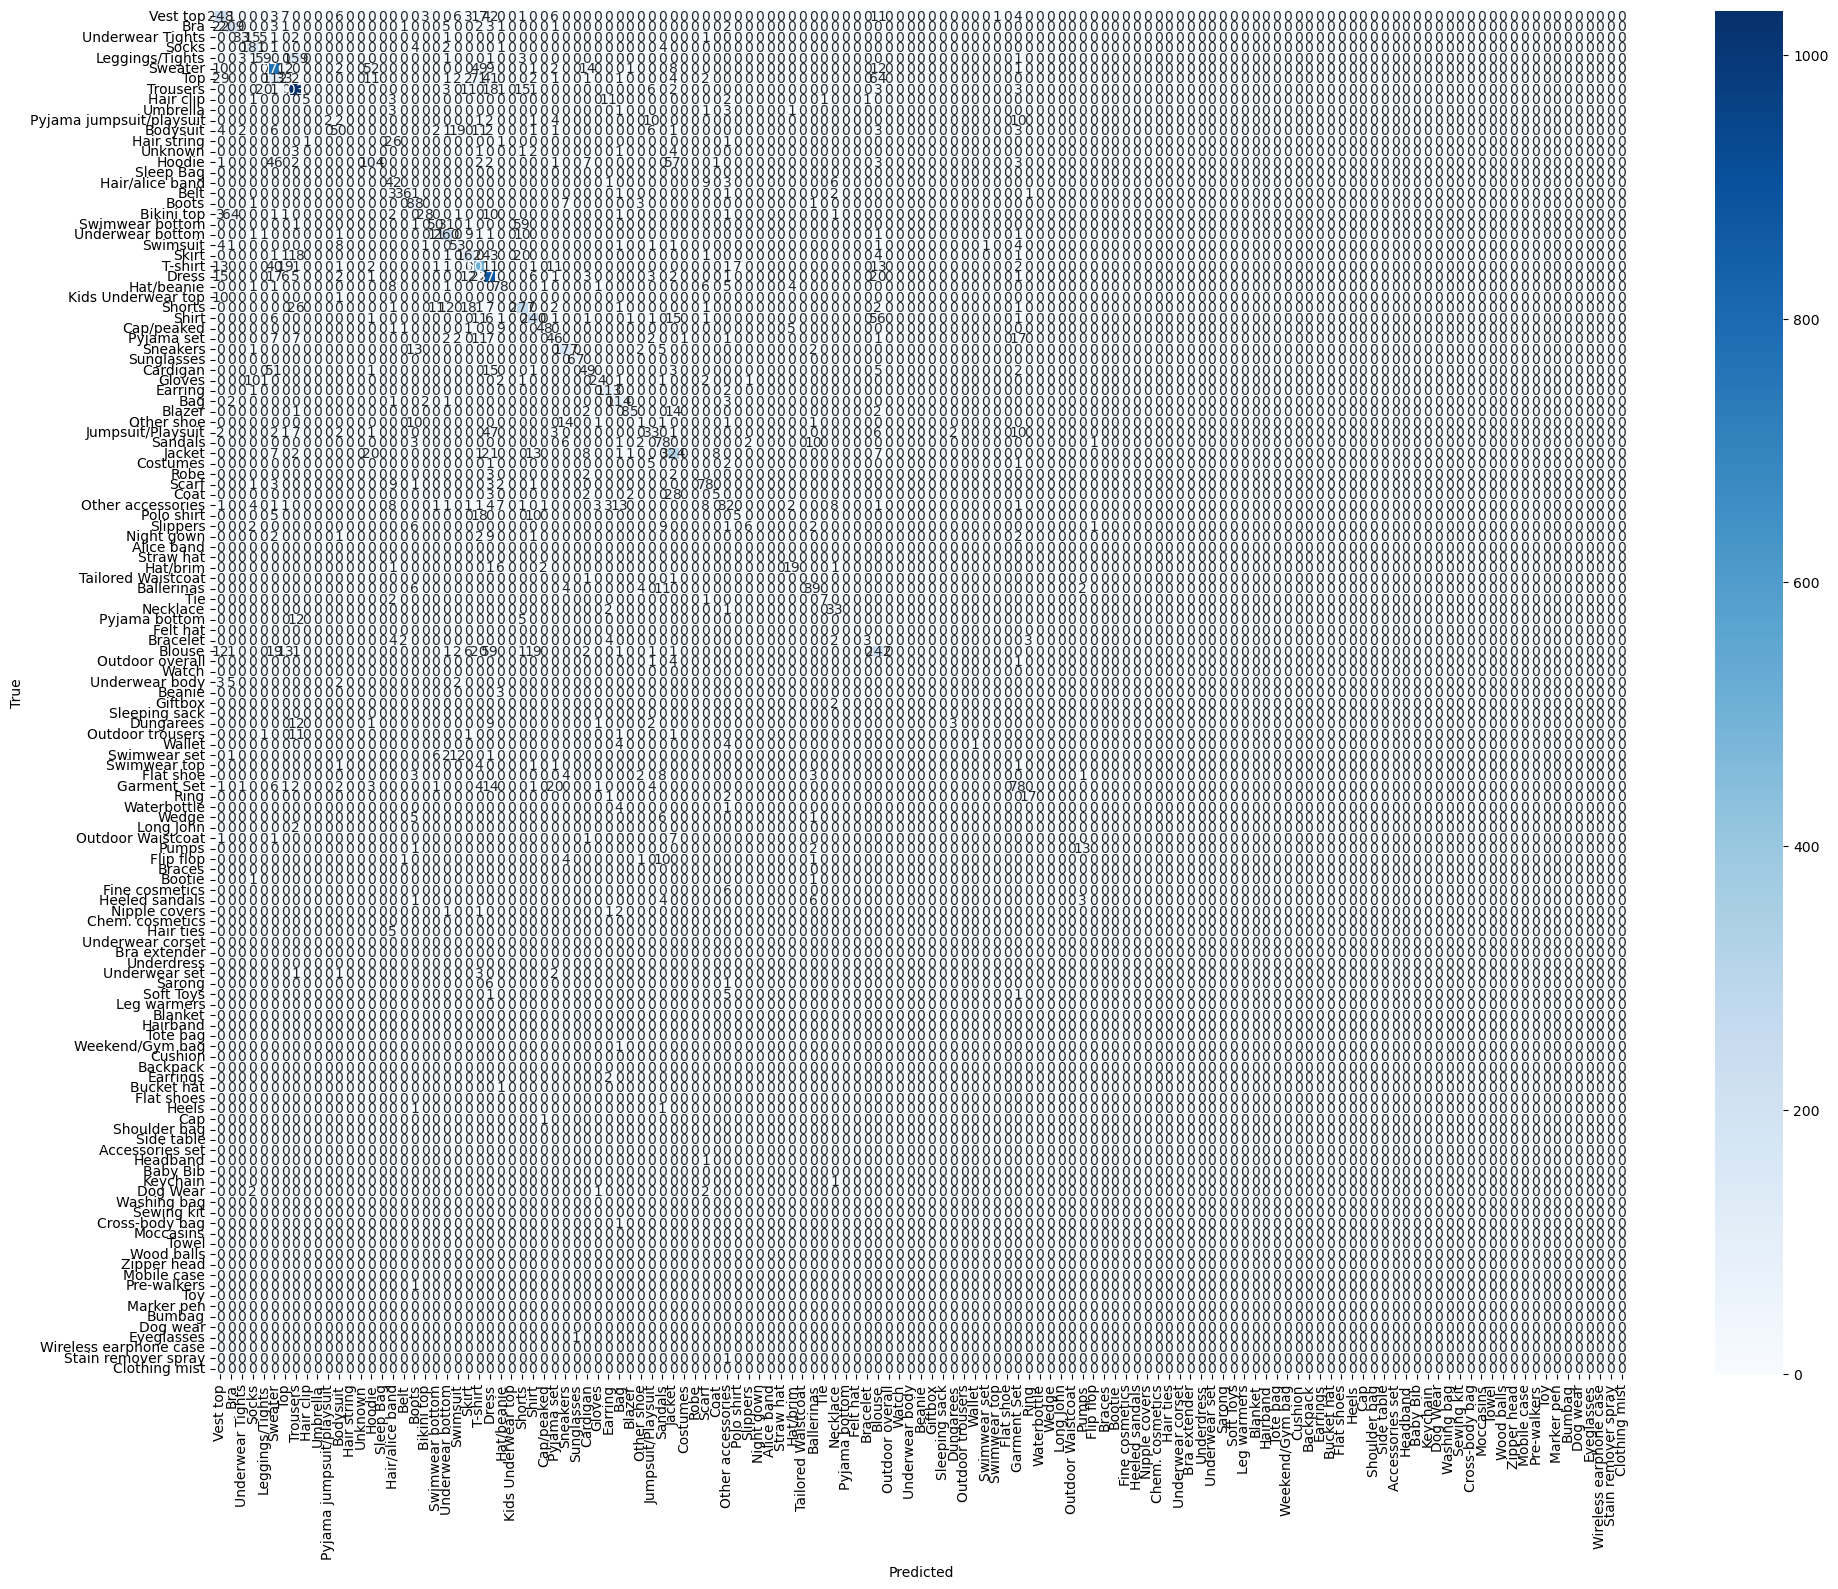

graphical_appearance_name: 0.7285249665199923
(30, 30)


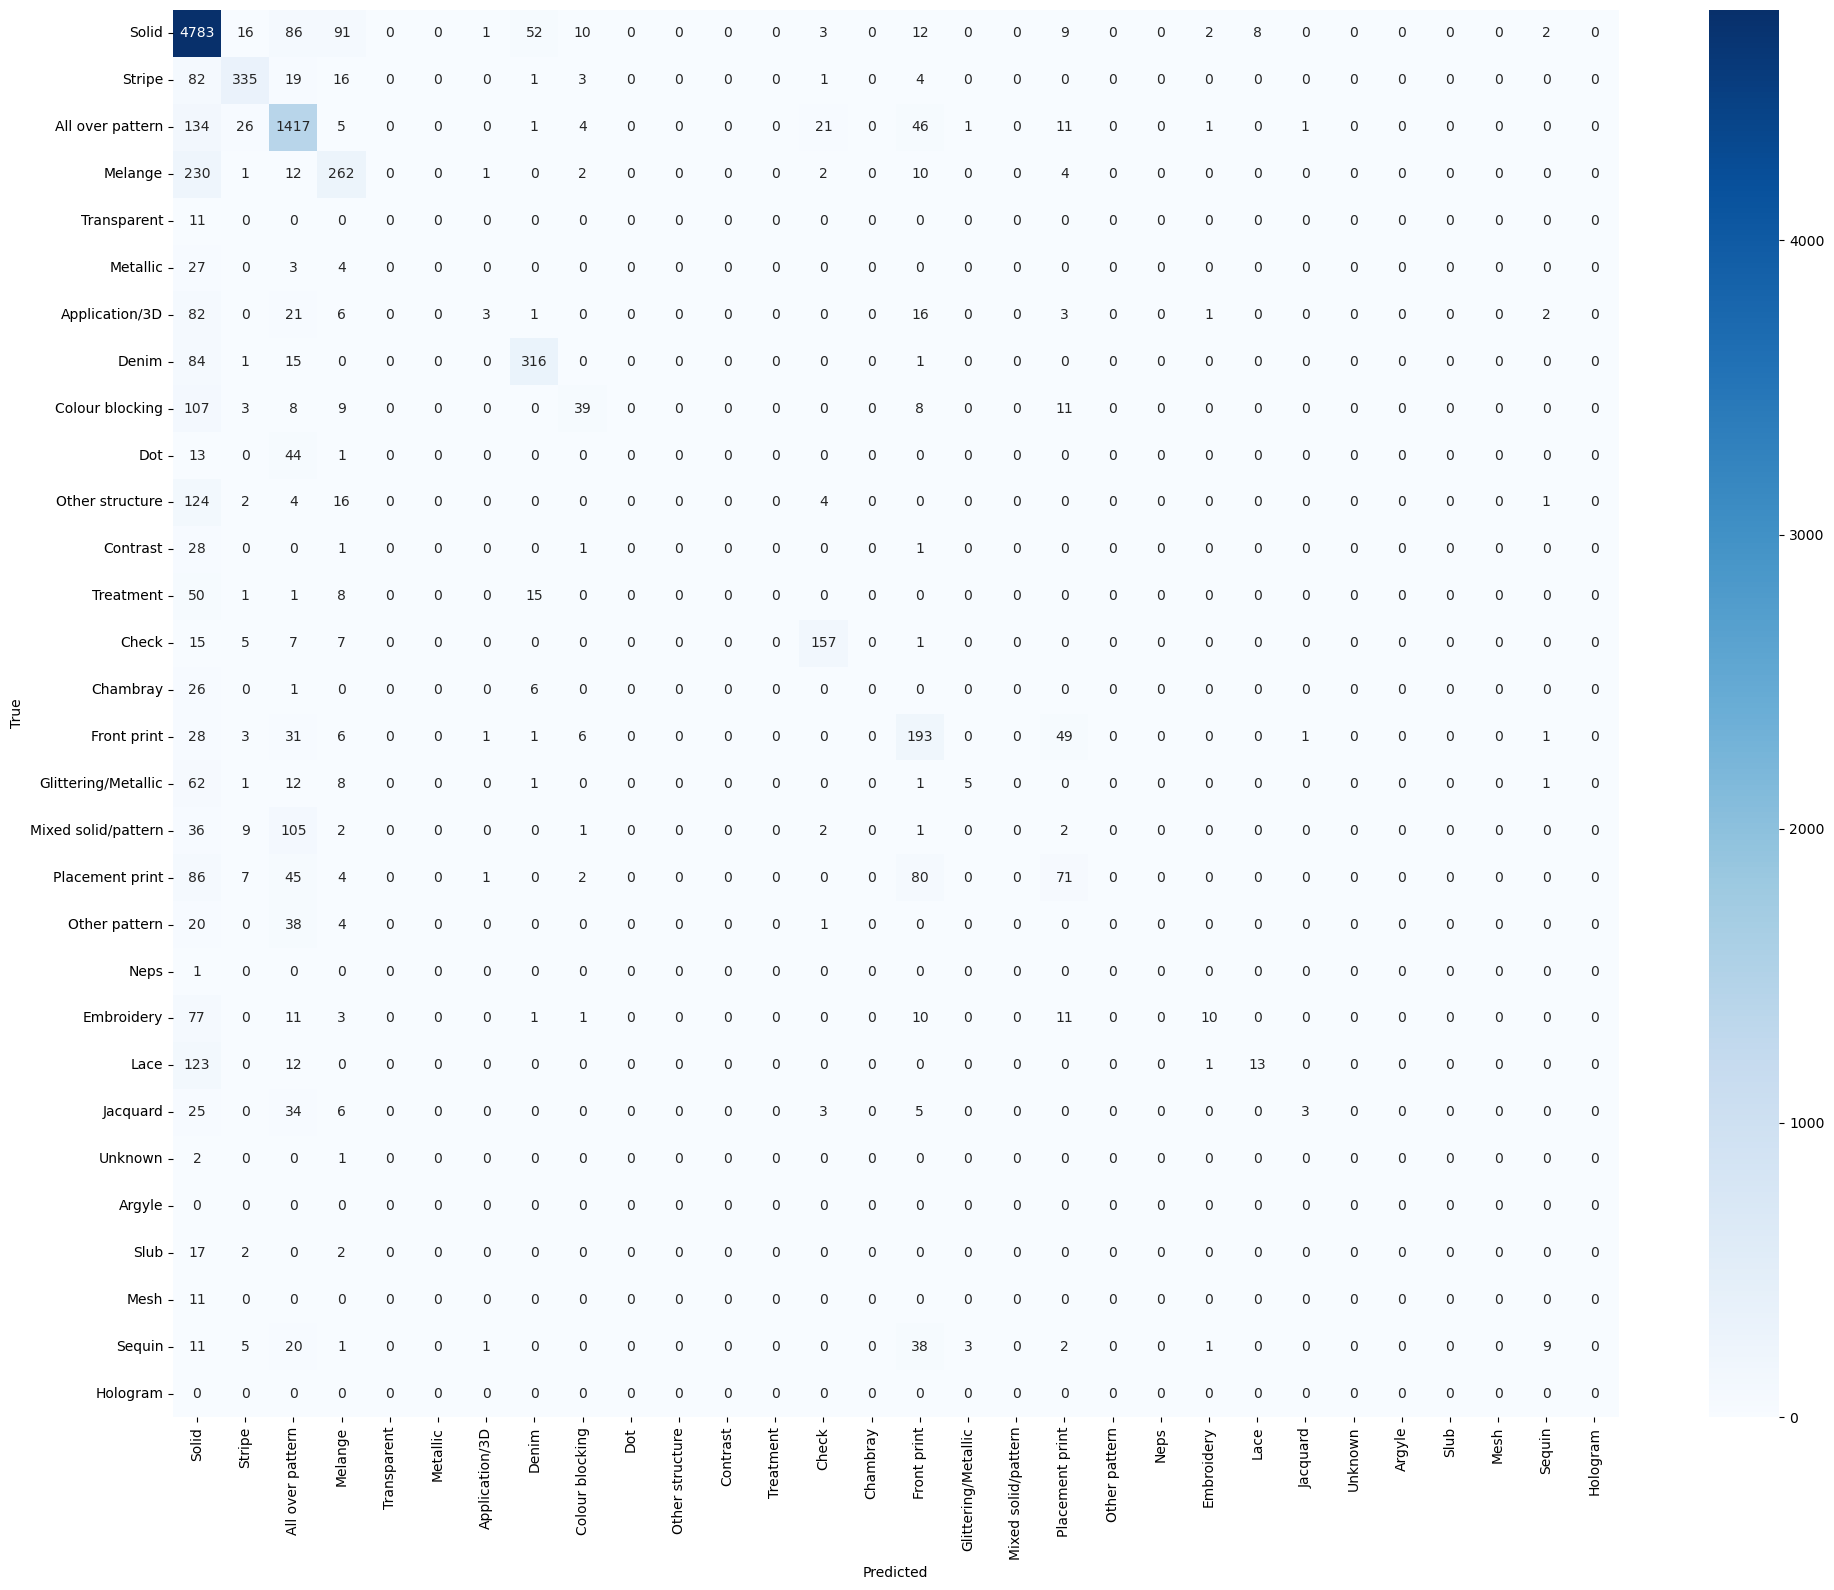

In [14]:
for class_name in selected_class_names:
    labels = label_dict[class_name].numpy()
    preds = pred_dict[class_name].numpy().argmax(axis=1)

    # calculate accuracy
    accuracy = np.mean(preds == labels)
    print(f"{class_name}: {accuracy}")

    # calculate confusion matrix 
    conf_matrix = confusion_matrix(labels, preds, labels=list(range(len(label_names[class_name]))))
    print(conf_matrix.shape)

    # plot confusion matrix, smaller number font size
    plt.figure(figsize=(20, 16))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names[class_name], yticklabels=label_names[class_name])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{class_name}.png")
    plt.show()

